In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from scipy.ndimage import gaussian_filter

import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer

model_dir = '/content/drive/MyDrive/Colab Notebooks/IKI projects/weights/model_24e_anc4-64.pth'

In [4]:
def apply_clahe(image, clip_limit, tile_grid_size=(10, 10)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_image = clahe.apply(image)
    clahe_image = clahe_image.astype(np.uint8)
    clahe_image = np.expand_dims(clahe_image, axis = 2)
    return clahe_image

def normalization(image_path, gauss=False, gauss_sigma=1, clahe=True, clahe_clip_limit=4.0, eps=10**-5):

    image = fits.getdata(os.path.join(image_path), memmap=False)
    len, wid = image.shape
    img = np.empty([len, wid, 1], dtype=np.uint8)
    image = np.nan_to_num(np.log10(image-np.amin(image)+eps), neginf=eps)

    if gauss:
      image = gaussian_filter(image, sigma=gauss_sigma)

    max_im = np.amax(image)
    max_dtype = np.iinfo(np.uint8).max
    coeff = max_dtype/max_im
    image *= coeff
    img[:,:,0] = image

    if clahe:
      img = apply_clahe(img, clip_limit=clahe_clip_limit)
    return img

# Mondy

In [5]:
cfg = get_cfg()
COCO = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(COCO))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[4, 8, 16, 32, 64]]
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.TEST.DETECTIONS_PER_IMAGE = 10000

# May be customized
cfg.MODEL.WEIGHTS = model_dir
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 4000 #default 1000
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 4000 #default 1000
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4
predictor = DefaultPredictor(cfg)

In [6]:
def prediction(image_path):
    predict = []

    ### clahe_clip_limit in [1:30], best for mondy - 10
    curim = normalization(image_path, gauss=False, clahe_clip_limit=10)
    outputs = predictor(curim)
    scores = outputs['instances'].scores.cpu().numpy()
    scores = np.expand_dims(scores, axis=1)
    curbox = outputs['instances'].pred_boxes.tensor.cpu().numpy()
    result = np.concatenate((curbox, scores), axis=1)
    return result

In [7]:
image_path = '/content/GRB230216A_230220_Mondy_60x60_sum_R.fit'

In [8]:
my_array = np.asarray(prediction(image_path))
np.savetxt("Mondy_1.csv", my_array, delimiter=" ,", fmt=" %.2f ")
print(my_array.shape)

<ipython-input-4-41b230af2ff0>:13: RuntimeWarning: invalid value encountered in log10
  image = np.nan_to_num(np.log10(image-np.amin(image)+eps), neginf=eps)
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(618, 5)


<ipython-input-134-41b230af2ff0>:13: RuntimeWarning: invalid value encountered in log10
  image = np.nan_to_num(np.log10(image-np.amin(image)+eps), neginf=eps)


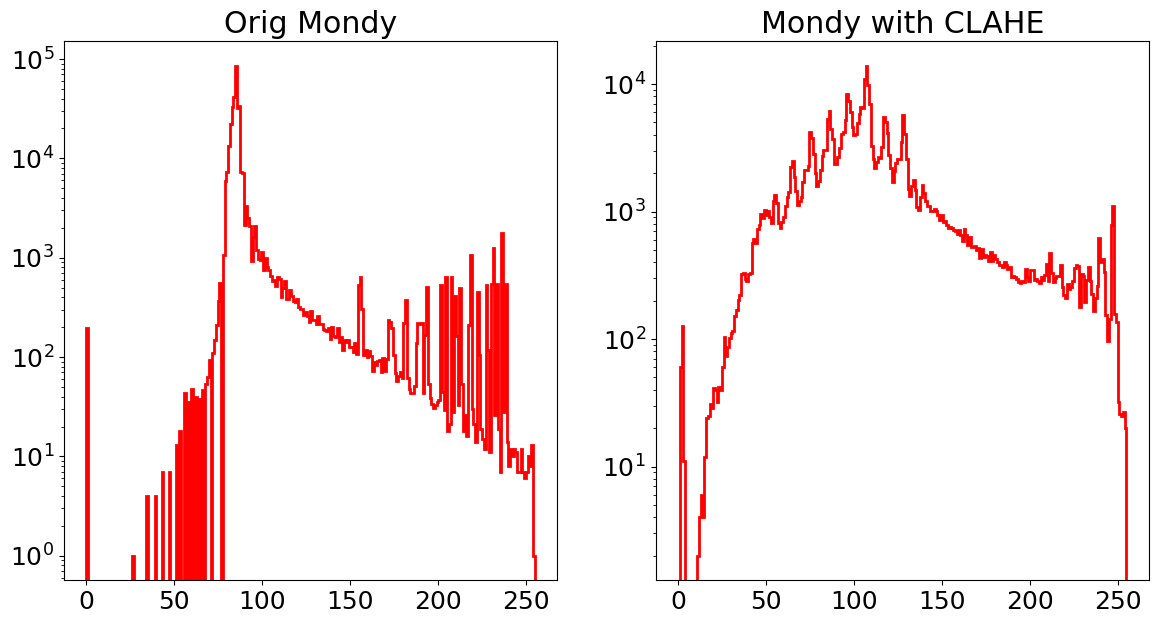

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharex='col')

for i, j in enumerate([image_path]):
    bins = 256
    rng=(0,255)
    axs[2*i].hist(normalization(image_path, gauss=False, clahe=False).flatten(), histtype="step", bins=bins, log=True, color="r", lw=2, zorder=1,range=rng);
    axs[2*i].set_title(f'Orig Mondy')
    axs[2*i+1].hist(normalization(image_path, gauss=False, clahe_clip_limit=10).flatten(), histtype="step", bins=bins, log=True, color="r", lw=2, zorder=1,range=rng);
    axs[2*i+1].set_title(f'Mondy with CLAHE')

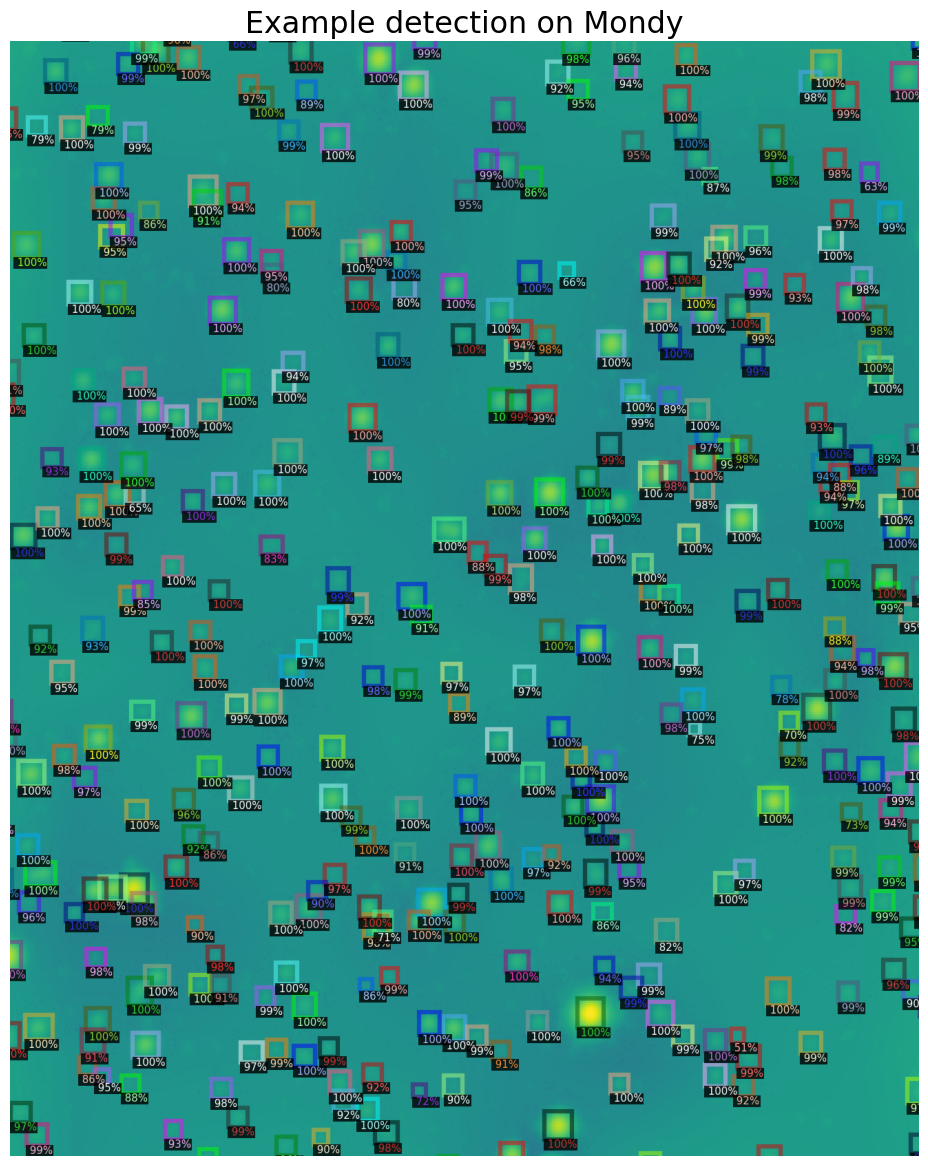

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
img_n = normalization(image_path)
outputs = predictor(img_n)
outputs["instances"].pred_masks = torch.zeros_like(outputs["instances"].pred_masks)


v = Visualizer(img_n,
               metadata=metadata,
               scale=3,
               instance_mode=ColorMode,#.IMAGE_BW
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
axs.imshow(out.get_image()[150:1770,150:1470])
plt.axis("off")
axs.set_title(f'Example detection on Mondy')
fig.tight_layout()
fig.show();

# AbAO

In [9]:
cfg = get_cfg()
COCO = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(COCO))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[4, 8, 16, 32, 64]]
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.TEST.DETECTIONS_PER_IMAGE = 100000

# May be customized
cfg.MODEL.WEIGHTS = model_dir
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 4000 #default 1000
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 4000 #default 1000
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4
predictor = DefaultPredictor(cfg)

In [10]:
def prediction(image_path):
    predict = []
    steps = 4
    shape_x, shape_y = 512, 512

    ### clahe_clip_limit in [1:10], best abao - 5
    cur_image = normalization(image_path, gauss=False, clahe_clip_limit=5)
    for x in range(steps):
      for y in range(steps):
        curim = cur_image[x*shape_x:(x+1)*shape_x, y*shape_y:(y+1)*shape_y]
        outputs = predictor(curim)
        scores = outputs['instances'].scores.cpu().numpy()
        scores = np.expand_dims(scores, axis=1)
        curbox = outputs['instances'].pred_boxes.tensor.cpu().numpy()
        curbox = np.concatenate((curbox, scores), axis=1)
        for i in range(curbox.shape[0]):
          for j in range(curbox.shape[1]-1):
            if j == 1 or j==3:
              curbox[i][j] += x*shape_x
            if j==0 or j==2:
              curbox[i][j] += y*shape_y
        for i in range(curbox.shape[0]):
          predict.append(curbox[i])
    return predict

In [11]:
image_path = '/content/sumGRB220306B_AbAO_R.fit'

In [12]:
my_array = np.asarray(prediction(image_path))
np.savetxt("abao_1.csv", my_array, delimiter=" ,", fmt=" %.2f ")
print(my_array.shape)

(4695, 5)


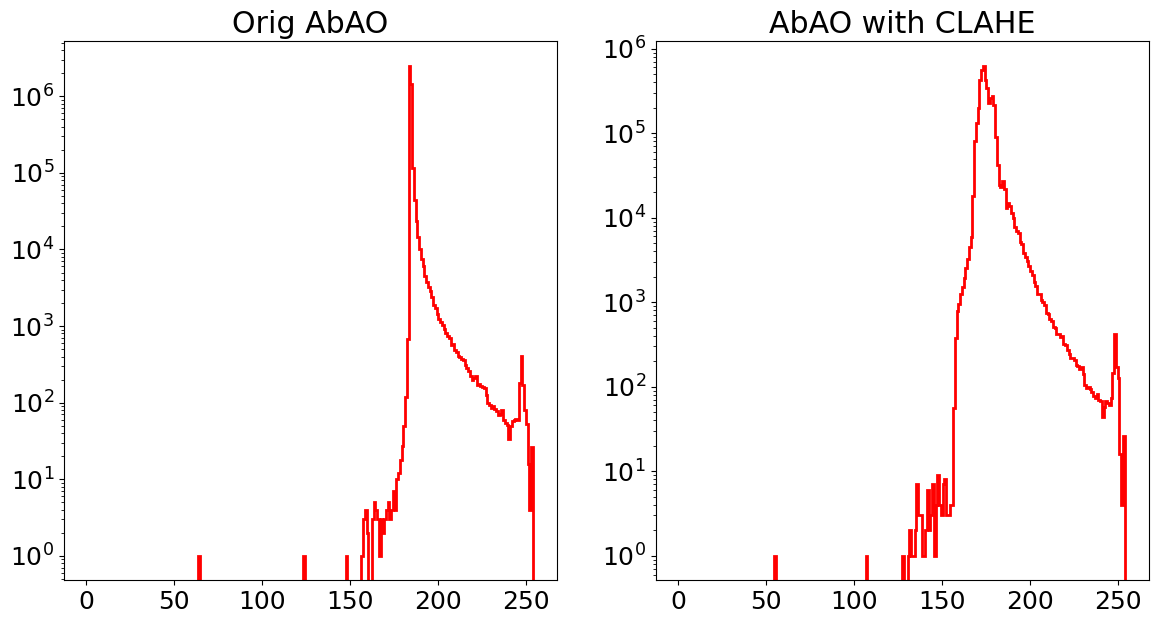

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharex='col')

for i, j in enumerate([image_path]):
    bins = 256
    rng=(0,255)
    axs[2*i].hist(normalization(image_path, gauss=False, clahe=False).flatten(), histtype="step", bins=bins, log=True, color="r", lw=2, zorder=1,range=rng);
    axs[2*i].set_title(f'Orig AbAO')
    axs[2*i+1].hist(normalization(image_path, gauss=False, clahe_clip_limit=5).flatten(), histtype="step", bins=bins, log=True, color="r", lw=2, zorder=1,range=rng);
    axs[2*i+1].set_title(f'AbAO with CLAHE')